<img src="images/JHI_STRAP_Web.png" style="width: 150px; float: right;">
# 09 - Programming for `KEGG`

## Table of Contents

1. [Introduction](#introduction)
2. [Python imports](#imports)
3. [Running a remote `KEGG` query](#kegg)
  1. [`kegg_info()`](#kegg_info)
  2. [`kegg_list()`](#kegg_list)
  2. [`kegg_find()`](#kegg_find)
  3. [`kegg_get()`](#kegg_get)
  4. [EXAMPLE: Putting it together](#example01)

<a id="introduction"></a>
## Introduction

The `KEGG` browser interface, while able to integrate searches across comprehensive and quite disparate datasets, does not always present the most convenient interface to extract that information (such as downloading FASTA sequences for an entry). As will all browser-based interfaces, it can also be tedious and time-consuming to point-and-click your way through a large number of browser-based searches.

This notebook presents examples of methods for using `KEGG` programmatically, via the Biopython programming libraries, and you will be controlling the searches using Python code in this notebook.

<div class="alert-success">
<b>As with all programmatic searches, there are a number of advantages to this approach:</b>
</div>

* It is easy to set up repeatable searches for many sequences, or collections of sequences
* It is easy to read in the search results and conduct downstream analyses that add value to your search

Where it is not practical to submit a large number of simultaneous queries via a web form (because it is tiresome to point-and-click over and over again), this can be handled programmatically instead. You have the opportunity to change custom options to help refine your query, compared to the website interface. If you need to repeat a query, it can be trivial to get the same settings every time, if you use a programmatic approach.

The Biopython interface to `KEGG` has several other advantages that we will not cover in this lesson, in that it allows for a much greater range of image manipulations for the pathway maps that `KEGG` returns.

<p></p>
<div class="alert-danger">
The `KEGG` interface is not as well documented as some other resources (such as `NCBI` or `Ensembl`), and `KEGG` does not provide any usage guidelines. To avoid risking overloading the service, Biopython restricts us to three calls per second. 
</div>

Be warned also that the conditions of service include:

> "This service should not be used for bulk data downloads".

<a id="imports"></a>
## Python imports

In [1]:
# Show plots as part of the notebook
%pylab inline

# Show images inline
from IPython.display import Image

# Standard library packages
import io
import os

# Import Biopython modules to interact with KEGG
from Bio import SeqIO
from Bio.KEGG import REST
from Bio.KEGG.KGML import KGML_parser
from Bio.Graphics.KGML_vis import KGMLCanvas

# Import Pandas, so we can use dataframes
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


### Python functions

In the cell below, we define a couple of useful functions that convert some returned output into Pandas dataframe form, and display `.pdf` images directly in the notebook. <div class="alert-danger"><b>You do not need to understand these to follow the lesson.</b></div>

In [2]:
# A bit of code that will help us display the PDF output
def PDF(filename):
    return HTML('<iframe src=%s width=700 height=350></iframe>' % filename)

# Some code to return a Pandas dataframe, given tabular text
def to_df(result):
    return pd.read_table(io.StringIO(result), header=None)

<a id="kegg"></a>
## Running a remote `KEGG` query

There is typically only a single step involved in obtaining a result from `KEGG` with Biopython: 

* **run one of the functions provided by `Bio.KEGG.REST`, and catch the result in a variable.**

The available functions are:

* `kegg_conv()` - convert identifiers from `KEGG` to those for other databases
* `kegg_find()` - find `KEGG` entries with matching query data
* `kegg_get()` - retrieve data for a specific entry from `KEGG` 
* `kegg_info()` - get information about a `KEGG` database
* `kegg_link()` - find entries in `KEGG` using a database cross-reference
* `kegg_list()` - list entries in a a database

The generic form of using these functions to get information from `KEGG` and place the output in the variable `myvar` is:

```
myvar = REST.<function>(<query>, <arg1>, <arg2>, `...`).read()
```

where `<function>` is one of the funcitons above, `<query>` is a string containing yoru query for `KEGG`, and `<arg1>`, `<arg2>` and so on are arguments that may be required for some of the functions.

You will use some of these functions in the notebook cells below to get information from `KEGG`.

<a id="kegg_info"></a>
### `kegg_info()`

This function returns basic information about a specified `KEGG` database - much like visiting the landing page for that database.

For instance, to get information about the `KEGG` databases as a whole, you can use `kegg_info("kegg")` to get a *handle* from `KEGG` describing the databases, and catch it in a variable:

```
result = REST.kegg_info("kegg").read()
```

We could convert this *handle* to a Pandas dataframe with the function defined above: `to_df()`:

```
to_df(result)
```

<div class="alert-danger">
<b>Not all data is suited to `pandas` dataframe representation</b>
</div>

or `.read()` the handle, and print it to output directly with the `print()` statement:

```
print(result)
```

In [3]:
# Perform the query
result = REST.kegg_info("kegg").read()

# Print the result
print(result)

# Convert result to dataframe
# NOTE: kegg_info() requests do not produce a suitable data format for dataframe representation
#to_df(result)

kegg             Kyoto Encyclopedia of Genes and Genomes
kegg             Release 81.0+/03-06, Mar 17
                 Kanehisa Laboratories
                 pathway     490,469 entries
                 brite       174,626 entries
                 module      395,093 entries
                 disease       1,749 entries
                 drug         10,443 entries
                 environ         850 entries
                 orthology    20,696 entries
                 genome        5,002 entries
                 genes     21,576,524 entries
                 dgenes              entries
                 compound     17,935 entries
                 glycan       11,015 entries
                 reaction     10,478 entries
                 rpair               entries
                 rclass        3,100 entries
                 enzyme        6,896 entries



This gives us a similar overview to the available resources as the [`KEGG` landing page](http://www.genome.jp/kegg/kegg2.html). However, the `kegg_info()` function is a little more powerful, as it can find information about specific databases:

In [4]:
# Print information about the PATHWAY database
result = REST.kegg_info("pathway").read()
print(result)

pathway          KEGG Pathway Database
path             Release 81.0+/03-06, Mar 17
                 Kanehisa Laboratories
                 490,469 entries



and even about specific organisms (identified with their three-letter code):

In [5]:
# Print information about Kitasatospora setae
result = REST.kegg_info("ksk").read()
print(result)

T01648           Kitasatospora setae KEGG Genes Database
ksk              Release 81.0+/03-03, Mar 17
                 Kanehisa Laboratories
                 7,673 entries



<a id="kegg_list"></a>
### `kegg_list()`

The `kegg_list()` function returns a table of entry identifiers and definitions for a specified database. For example, to list all the entries in the PATHWAY database, you could use:

In [6]:
# Get all entries in the PATHWAY database as a dataframe
result = REST.kegg_list("pathway").read()
to_df(result)

,0,1
0,path:map00010,Glycolysis / Gluconeogenesis
1,path:map00020,Citrate cycle (TCA cycle)
2,path:map00030,Pentose phosphate pathway
3,path:map00040,Pentose and glucuronate interconversions
4,path:map00051,Fructose and mannose metabolism
5,path:map00052,Galactose metabolism
6,path:map00053,Ascorbate and aldarate metabolism
7,path:map00061,Fatty acid biosynthesis
8,path:map00062,Fatty acid elongation
9,path:map00071,Fatty acid degradation


and to restrict the results only to those pathways that are present in *K. setae*, you can filter the database results with a query string `ksk`, as the second argument:

In [7]:
# Get all entries in the PATHWAY database for K. setae as a dataframe
result = REST.kegg_list("pathway", "ksk").read()
to_df(result)

,0,1
0,path:ksk00010,Glycolysis / Gluconeogenesis - Kitasatospora s...
1,path:ksk00020,Citrate cycle (TCA cycle) - Kitasatospora setae
2,path:ksk00030,Pentose phosphate pathway - Kitasatospora setae
3,path:ksk00040,Pentose and glucuronate interconversions - Kit...
4,path:ksk00051,Fructose and mannose metabolism - Kitasatospor...
5,path:ksk00052,Galactose metabolism - Kitasatospora setae
6,path:ksk00053,Ascorbate and aldarate metabolism - Kitasatosp...
7,path:ksk00061,Fatty acid biosynthesis - Kitasatospora setae
8,path:ksk00071,Fatty acid degradation - Kitasatospora setae
9,path:ksk00072,Synthesis and degradation of ketone bodies - K...


<div class="alert-warning">
<b>QUESTIONS</b>
<ol>
<li> How many entries are in the complete PATHWAY database
<li> How many entries in the PATHWAY database are also present in <i>K. setae</i>
<li> Are these the same answers you got in `lesson 08`?
</ol>
</div>

If, instead of specifying one of the top-level `KEGG` databases, you specify an organism code, `KEGG` will return a list of gene entries for that organism:

In [8]:
# Get all genes from K. setae as a dataframe
result = REST.kegg_list("ksk").read()
to_df(result)

,0,1
0,ksk:KSE_00010t,no KO assigned | (GenBank) ttrA1; putative hel...
1,ksk:KSE_00020t,no KO assigned | (GenBank) hypothetical protein
2,ksk:KSE_00030t,no KO assigned | (GenBank) hypothetical protein
3,ksk:KSE_00040t,no KO assigned | (GenBank) hypothetical protein
4,ksk:KSE_00060t,no KO assigned | (GenBank) putative helicase
5,ksk:KSE_00070t,no KO assigned | (GenBank) hypothetical protein
6,ksk:KSE_00080t,no KO assigned | (GenBank) hypothetical protein
7,ksk:KSE_00090t,no KO assigned | (GenBank) hypothetical protein
8,ksk:KSE_00100t,no KO assigned | (GenBank) hypothetical protein
9,ksk:KSE_00110t,no KO assigned | (GenBank) hypothetical protein


<a id="kegg_find"></a>
### `kegg_find()`

The `kegg_find()` function will search a named `KEGG` database with a specified query term. For instance, to query the GENES database with the entry accession `KSE_17560` you could use:

In [9]:
# Find a specific entry with a precise search term
result = REST.kegg_find("genes", "KSE_17560").read()
to_df(result)

,0,1
0,ksk:KSE_17560,K01662 1-deoxy-D-xylulose-5-phosphate synthase...


With the query above, `KEGG` returns information for the exact entry we've requested. But we can also use less precise search terms, and combine them with the `+` symbol. For example, to search for `shiga toxin` we would use the query:

```
"shiga+toxin"
```

In [10]:
# Find all shiga toxin genes
result = REST.kegg_find("genes", "shiga+toxin").read()
to_df(result)

,0,1
0,ece:Z1464,K11006 shiga toxin subunit A | (GenBank) stx2A...
1,ece:Z1465,K11007 shiga toxin subunit B | (GenBank) stx2B...
2,ece:Z3343,K11007 shiga toxin subunit B | (GenBank) stx1B...
3,ece:Z3344,K11006 shiga toxin subunit A | (GenBank) stx1A...
4,ecs:ECs1205,K11006 shiga toxin subunit A | (RefSeq) Shiga ...
5,ecs:ECs1206,K11007 shiga toxin subunit B | (RefSeq) Shiga ...
6,ecs:ECs2973,K11007 shiga toxin subunit B | (RefSeq) Shiga ...
7,ecs:ECs2974,K11006 shiga toxin subunit A | (RefSeq) Shiga ...
8,ecf:ECH74115_2905,K11007 shiga toxin subunit B | (GenBank) shiga...
9,ecf:ECH74115_2906,K11006 shiga toxin subunit A | (GenBank) shiga...


We can restrict this search to specific organisms, such as *Escherichia coli* O111 H-11128 (EHEC), by supplying its three letter code (here, `eoi`) as the database to be searched:

In [11]:
# Find all shiga toxin genes in eoi
result = REST.kegg_find("eoi", "shiga+toxin").read()
to_df(result)

,0,1
0,eoi:ECO111_2429,K11007 shiga toxin subunit B | (GenBank) Shiga...
1,eoi:ECO111_2430,K11006 shiga toxin subunit A | (GenBank) Shiga...
2,eoi:ECO111_3361,K11006 shiga toxin subunit A | (GenBank) Shiga...
3,eoi:ECO111_3362,K11007 shiga toxin subunit B | (GenBank) Shiga...


The `kegg_find()` query string can also search in specific *fields* of the entry. The format for this is:

```
<query_value>/<field>
```

So, to search for all compounds with a molecular weight between 300 and 310 mass units, you can use the code:

In [12]:
# Find all compounds with mass between 300 and 310 units
result = REST.kegg_find("compound", "300-310/mol_weight").read()
to_df(result)

,0,1
0,cpd:C00051,307.323480
1,cpd:C00200,306.336960
2,cpd:C00219,304.466880
3,cpd:C00239,307.197122
4,cpd:C00270,309.269860
5,cpd:C00357,301.187702
6,cpd:C00365,308.181882
7,cpd:C00389,302.235700
8,cpd:C00732,308.372760
9,cpd:C00777,300.435120


<a id="kegg_get"></a>
### `kegg_get()`

Most functions you've seen so far will return two columns of data: the first column being the entry accession, and the second column being a description of that entry, or the requested value.

The `kegg_get()` function lets us retrieve specific entries from `KEGG` - such as our search results - in named formats.

For example, the first compound in our search for molecular weights in the range 300-310 above has entry accession `cpd:C00051`. We can recover this entry as follows:

In [13]:
# Get the entry information for cpd:C00051
result = REST.kegg_get("cpd:C00051").read()
print(result)

ENTRY       C00051                      Compound
NAME        Glutathione;
            5-L-Glutamyl-L-cysteinylglycine;
            N-(N-gamma-L-Glutamyl-L-cysteinyl)glycine;
            gamma-L-Glutamyl-L-cysteinyl-glycine;
            GSH;
            Reduced glutathione
FORMULA     C10H17N3O6S
EXACT_MASS  307.0838
MOL_WEIGHT  307.3235
REMARK      Same as: D00014
REACTION    R00094 R00115 R00120 R00274 R00494 R00497 R00499 R00527 
            R00547 R00900 R01108 R01109 R01110 R01111 R01113 R01262 
            R01292 R01736 R01875 R01917 R01918 R02530 R02824 R03059 
            R03082 R03167 R03522 R03822 R03915 R03956 R03984 R04039 
            R04090 R04860 R05267 R05269 R05402 R05403 R05714 R05717 
            R05748 R06982 R07002 R07003 R07004 R07023 R07024 R07025 
            R07026 R07034 R07035 R07069 R07070 R07083 R07084 R07091 
            R07092 R07093 R07094 R07100 R07113 R07116 R07124 R08280 
            R08350 R08351 R08352 R08353 R08354 R08355 R08511 R08512 
            

<div class="alert-warning">
<b>QUESTIONS</b>
<ol>
<li> What information is returned in the default result?
</ol>
</div>

`KEGG` provides a number of different entry types, which cannot all be recovered in exactly the same ways. For instance, the COMPOUND entries typically have an associated molecular structure image, which can be recovered with `kegg_get()` by specifying the format to be `"image"`:

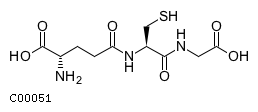

In [14]:
# Display molecular structure for cpd:C00051
result = REST.kegg_get("cpd:C00051", "image").read()
Image(result)

GENE entries are sequences, so can be recovered as their database entries (default), or as FASTA format nucleotide and/or protein sequences:

In [15]:
# Get entry information for KSE_17560
result = REST.kegg_get("ksk:KSE_17560").read()
print(result)

ENTRY       KSE_17560         CDS       T01648
NAME        dxs1
DEFINITION  (GenBank) putative 1-deoxy-D-xylulose-5-phosphate synthase
ORTHOLOGY   K01662  1-deoxy-D-xylulose-5-phosphate synthase [EC:2.2.1.7]
ORGANISM    ksk  Kitasatospora setae
PATHWAY     ksk00730  Thiamine metabolism
            ksk00900  Terpenoid backbone biosynthesis
            ksk01100  Metabolic pathways
            ksk01110  Biosynthesis of secondary metabolites
            ksk01130  Biosynthesis of antibiotics
MODULE      ksk_M00096  C5 isoprenoid biosynthesis, non-mevalonate pathway
BRITE       KEGG Orthology (KO) [BR:ksk00001]
             Metabolism
              Metabolism of cofactors and vitamins
               00730 Thiamine metabolism
                KSE_17560 (dxs1)
              Metabolism of terpenoids and polyketides
               00900 Terpenoid backbone biosynthesis
                KSE_17560 (dxs1)
            Enzymes [BR:ksk01000]
             2. Transferases
              2.2  Transferring al

In [16]:
# Get coding sequence for KSE_17560
result = REST.kegg_get("ksk:KSE_17560", "ntseq").read()
print(result)

>ksk:KSE_17560 K01662 1-deoxy-D-xylulose-5-phosphate synthase [EC:2.2.1.7] | (GenBank) dxs1; putative 1-deoxy-D-xylulose-5-phosphate synthase (N)
atgccactgctgagccagatcaccgggcccgccgacctcagacgactgcaccccgagcag
ctgccgctgctcgccgacgagatccgcgacttcctgatcgacgccgtcacccgcaccggc
ggccacctcggccccaacctcggcgtggtcgagctcagcatcgccctacaccgggtcttc
gactccccgcgcgaccgcgtcctgtgggacaccggccaccaggcctacgtgcacaagctg
ctcaccggccggcaggacttcagccggctgcgcgccaaggacggcctctccggctacccc
tcgcgcgccgagtccgaacacgacctgatcgagaactcgcacgcctccaccgcgctcggc
tacgccgacggcatcgccaaggccaaccaactgctcggcgccgaccggcacaccgtcgcc
gtgatcggcgacggcgcgctcaccggcggcatggcctgggaggcgctcaacaacatcgcc
gaggccgaggaccgcccgctggtcatcgtcgtcaacgacaacgagcgctcctacgcgccc
accatcggcggcctcgcccaccacctcgccaccctgcgcaccacccgcggctacgagcgc
ttcctcgcctggggcaaggacgccctgcagcgcacccccgtggtcgggccgccgctgttc
gacgcgctgcacggcgccaagaagggcttcaaggacgccttcgccccgcagggcatgttc
gaggacctcggtctgaagtacctcggcccgatcgacggccacgacatcgccgccgtcgaa
caggcgctgcgccaggcccggaacttcggcgggcccgtcatcgtgcactgcctgaccgtc


In [17]:
# Get protein sequence for KSE_17560
result = REST.kegg_get("ksk:KSE_17560", "aaseq").read()
print(result)

>ksk:KSE_17560 K01662 1-deoxy-D-xylulose-5-phosphate synthase [EC:2.2.1.7] | (GenBank) dxs1; putative 1-deoxy-D-xylulose-5-phosphate synthase (A)
MPLLSQITGPADLRRLHPEQLPLLADEIRDFLIDAVTRTGGHLGPNLGVVELSIALHRVF
DSPRDRVLWDTGHQAYVHKLLTGRQDFSRLRAKDGLSGYPSRAESEHDLIENSHASTALG
YADGIAKANQLLGADRHTVAVIGDGALTGGMAWEALNNIAEAEDRPLVIVVNDNERSYAP
TIGGLAHHLATLRTTRGYERFLAWGKDALQRTPVVGPPLFDALHGAKKGFKDAFAPQGMF
EDLGLKYLGPIDGHDIAAVEQALRQARNFGGPVIVHCLTVKGRGYRPAEQDEADRFHAVG
PIDPYTCLPISPSAGASWTSVFSQEMLALGAERPDLVAVTAAMLHPVGLGPFAAAHPGRT
YDVGIAEQHAVASAAGLATGGLHPVVAVYATFLNRAFDQVLMDVALHKLGVTFVLDRAGV
TGNDGASHNGMWDMSILQVVPGLRLAAPRDADRLREQLREAVAVEDAPTVVRFPKGDLGP
EIPAVERIGGVDVLARTGPSPDVLLVAVGSMAPACLDAAALLAAEGITATVVDPRWVKPV
DPALVALAAAHRMVVTVEDNGRAGGVGAAVAQAMRDAEVDTPLRDLGVPQEFLAHASRGE
ILEEIGLTGTGVAAQTAAYARRLLPGTRSGAQEYRPRVPRK



<a id="pathways"></a>
### Retrieving pathways

`KEGG` is practically synonymous with its excellent pathway diagrams, and it should be no surprise that you can retrive these using Python, too. You can get these images directly with `kegg_get()`, using the `"image"` format.

To specify one of the generic pathway maps, you can combine the `map` prefix with the pathway number to make the query `mapNNNNN` as in the cells, below.

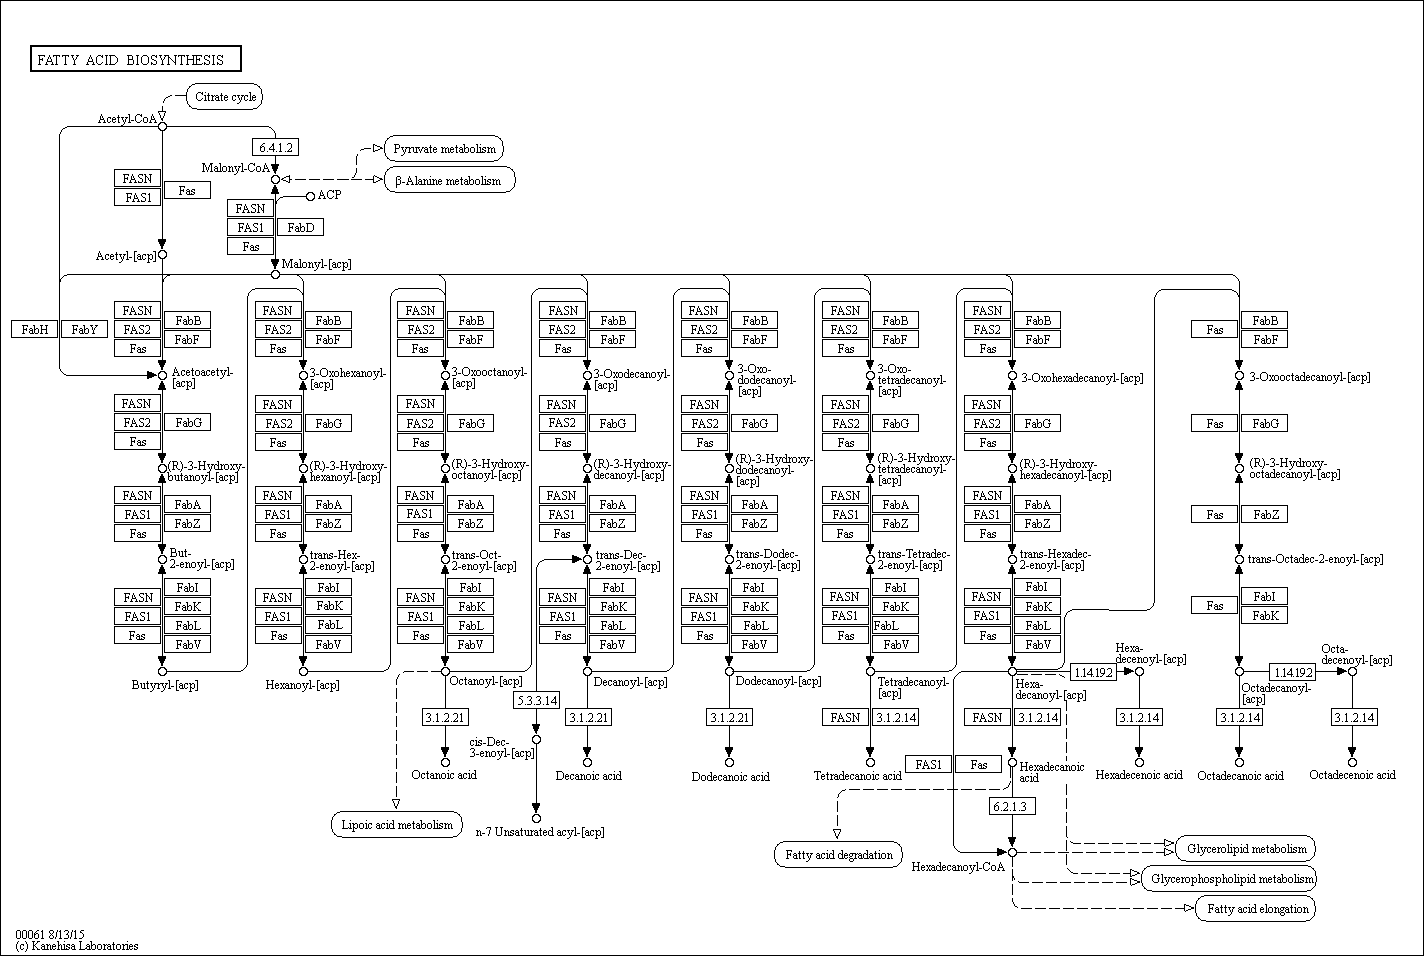

In [18]:
# Get map of fatty-acid biosynthesis
result = REST.kegg_get("map00061", "image").read()
Image(result)

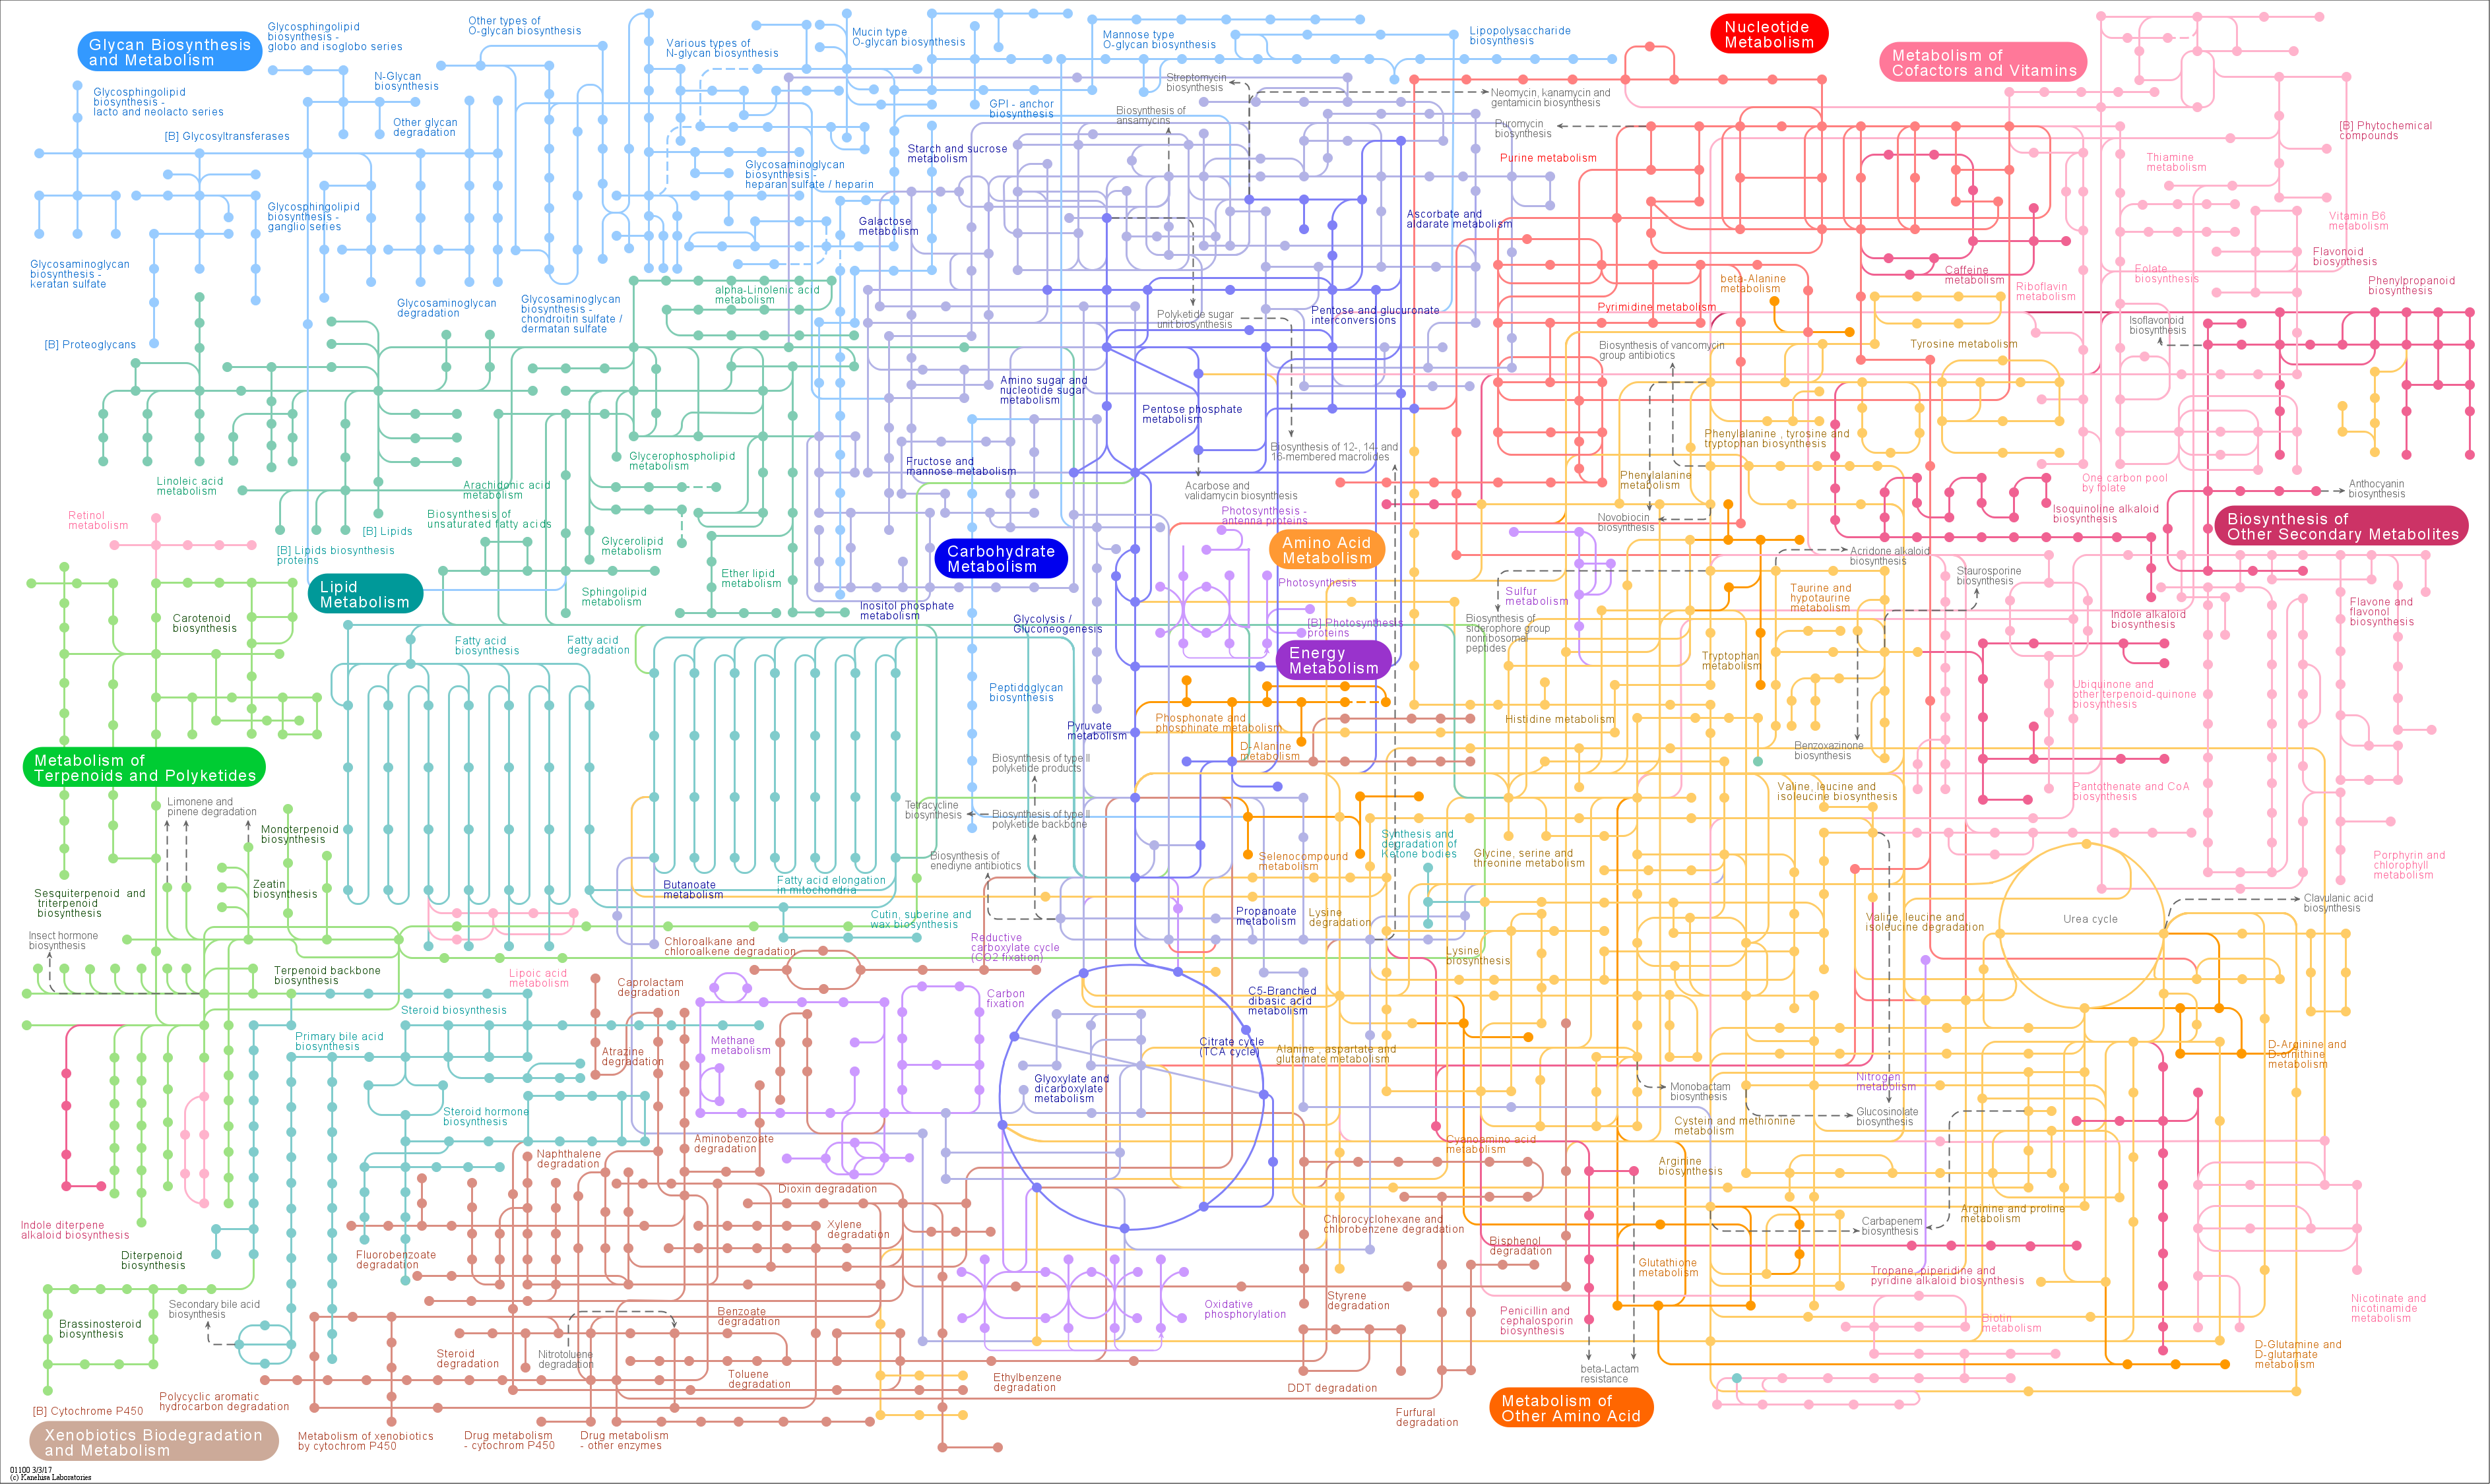

In [19]:
# Get map of central metabolism
result = REST.kegg_get("map01100", "image").read()
Image(result)

If you want to retrieve the pathway map corresponding to a particular organism, then you can replace the prefix `map` with the three-letter code for that organism, as in the examples below for *Kitasatospora* where `map` is replaced with `ksk`:

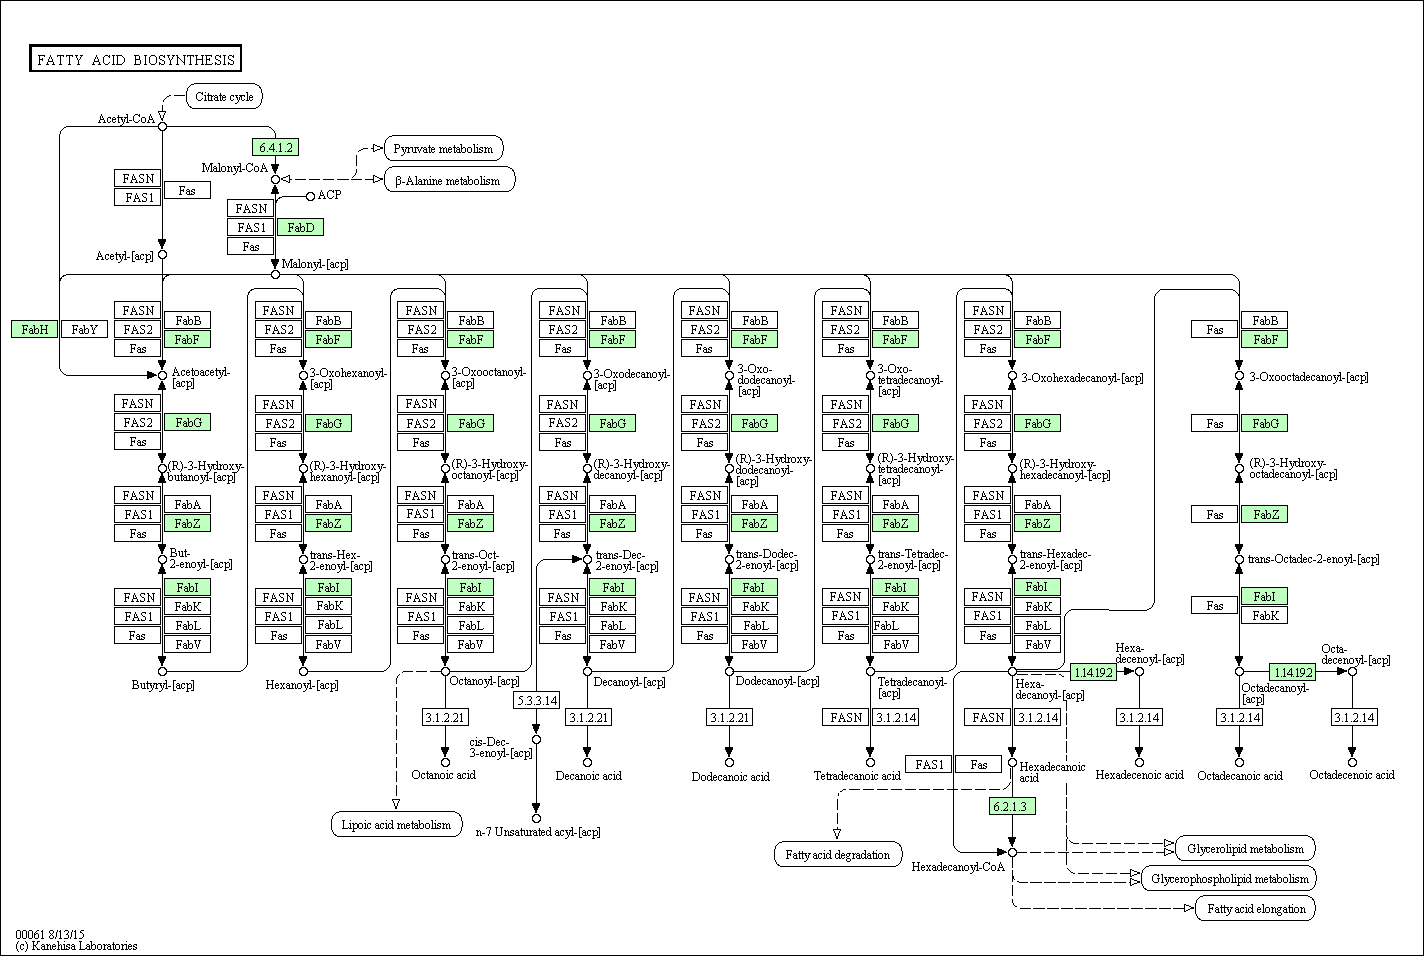

In [20]:
# Get map of fatty-acid biosynthesis in Kitasatospora
result = REST.kegg_get("ksk00061", "image").read()
Image(result)

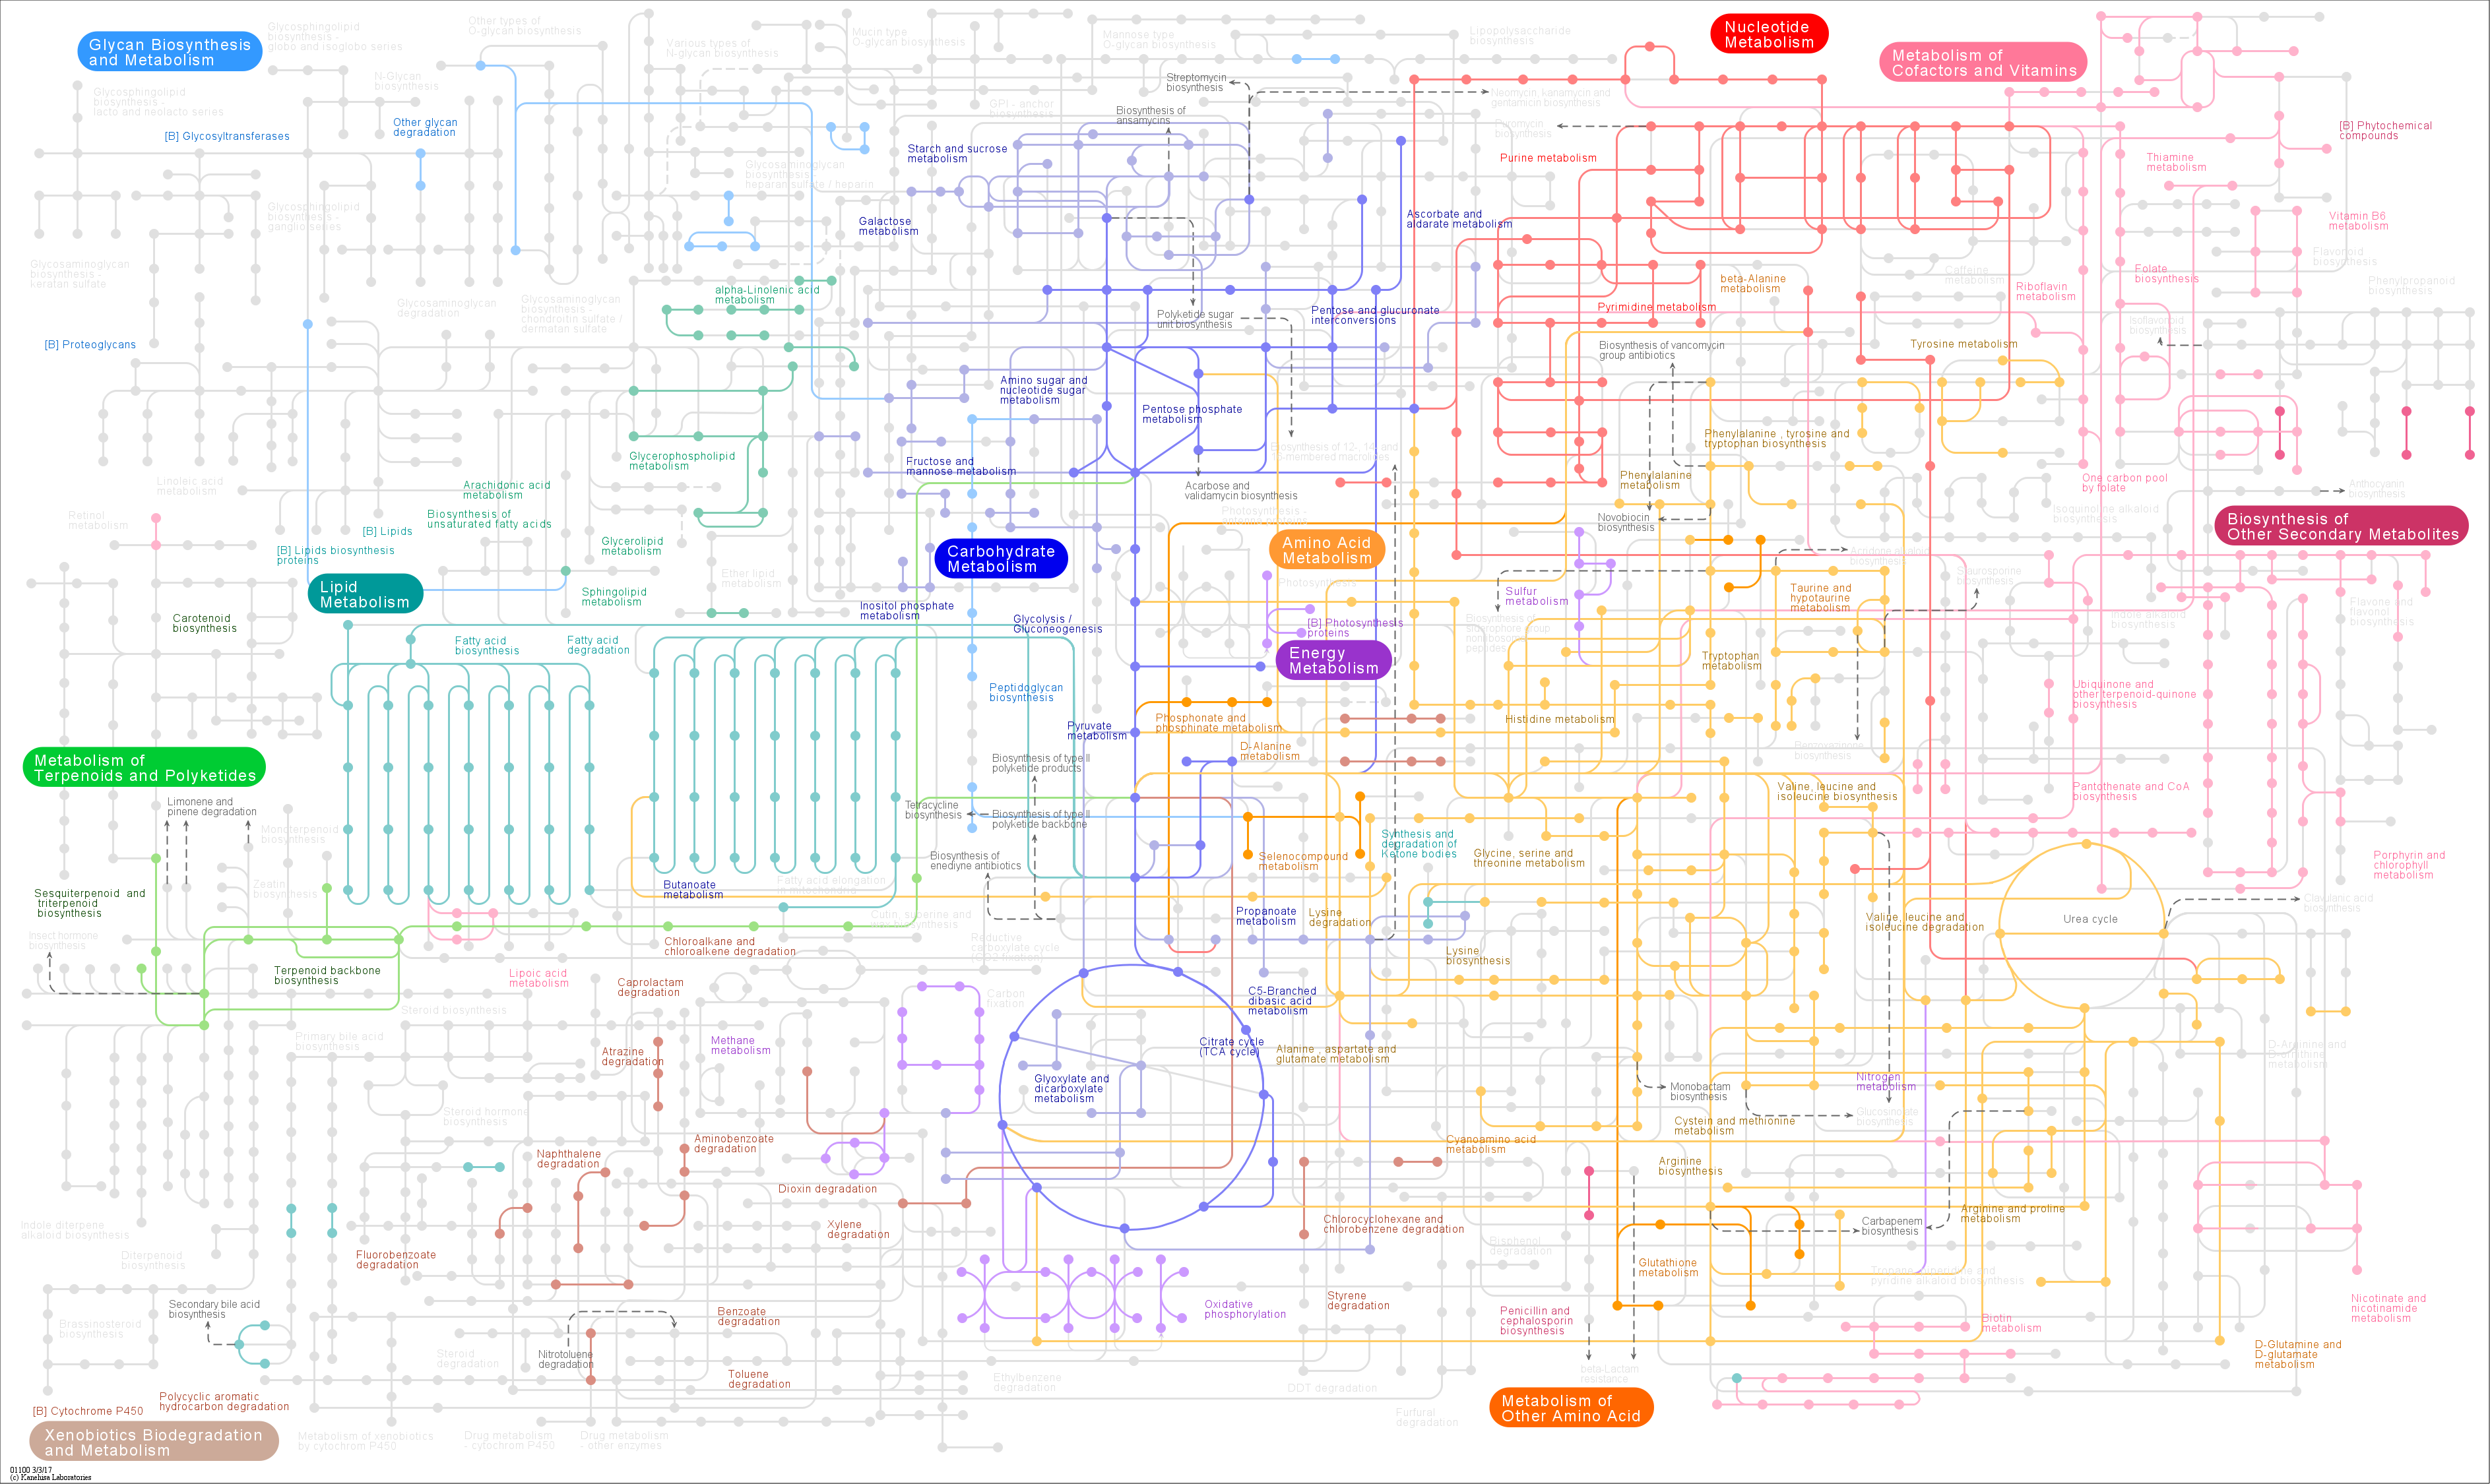

In [21]:
# Get map of central metabolism in Kitasatospora
result = REST.kegg_get("ksk01100", "image").read()
Image(result)

`KEGG` provides copious information about pathways in the accompanying database entries, which can be obtained by not providing a download format:

In [22]:
# Get data for fatty-acid biosynthesis in Kitasatospora
result = REST.kegg_get("ksk00061").read()
print(result)

ENTRY       ksk00061                    Pathway
NAME        Fatty acid biosynthesis - Kitasatospora setae
CLASS       Metabolism; Lipid metabolism
PATHWAY_MAP ksk00061  Fatty acid biosynthesis
MODULE      ksk_M00082  Fatty acid biosynthesis, initiation [PATH:ksk00061]
            ksk_M00083  Fatty acid biosynthesis, elongation [PATH:ksk00061]
ORGANISM    Kitasatospora setae [GN:ksk]
GENE        KSE_65020  putative acyl-CoA carboxylase [KO:K01962 K01963] [EC:6.4.1.2 6.4.1.2]
            KSE_72490  putative acyl-CoA carboxylase [KO:K01962 K01963] [EC:6.4.1.2 6.4.1.2]
            KSE_72500  putative acyl-CoA carboxylase [KO:K02160]
            KSE_72510  putative acyl-CoA carboxylase [KO:K01961] [EC:6.3.4.14 6.4.1.2]
            KSE_26830  accA; putative acetyl-CoA carboxylase biotin carboxylase [KO:K11263] [EC:6.3.4.14 6.4.1.3 6.4.1.2]
            KSE_29850  putative propionyl-CoA carboxylase alpha subunit [KO:K11263] [EC:6.3.4.14 6.4.1.3 6.4.1.2]
            KSE_24970  fabD1; putative m

<a id="links"></a>
### Retrieving pathway components

As you can see from the database entry for `ksk00061` above, the pathway is composed of many `GENE` and `COMPOUND` entries, but the returned data format is not easy to work with to extract that data.

You can use the `kegg_link()` function to identify the components of a pathway, by specifying first the `<database>` you want to make a connection to, then the `<entry_id>` for the database entry you are interested in:

```
result = REST.kegg_link(<database>, <entry>).read()
```


For instance, to identify the `GENE` entries represented in the `ksk00061` pathway, you would compose the query:

```
result = REST.kegg_link("genes", "ksk00061").read()
```

as below:

In [23]:
# Get genes involved with fatty-acid biosynthesis in Kitasatospora
result = REST.kegg_link("genes", "ksk00061").read()
to_df(result)

,0,1
0,path:ksk00061,ksk:KSE_08640
1,path:ksk00061,ksk:KSE_11260
2,path:ksk00061,ksk:KSE_15050
3,path:ksk00061,ksk:KSE_17190
4,path:ksk00061,ksk:KSE_17510
5,path:ksk00061,ksk:KSE_21700
6,path:ksk00061,ksk:KSE_24970
7,path:ksk00061,ksk:KSE_24980
8,path:ksk00061,ksk:KSE_25000
9,path:ksk00061,ksk:KSE_25760


You can use any of the databases in `KEGG` with this function, though not all may give you a result for any given query.

You can use this function to query generic pathways against the very useful reference databases of `KEGG`:

* `ko`: `KEGG` orthologues - a collection of functional orthologues
* `ec`: `EC` numbers - a collection of Enzyme Commission classifications
* `rn`: `REACTION` entries - descriptions of chemical interconversions

For example, to identify reactions that are involved in the fatty-acid synthesis pathway, and then get the database entry for one of these, you could use the queries in the cells below:

In [24]:
# Get reactions involved with fatty-acid biosynthesis
result = REST.kegg_link("rn", "map00061").read()
to_df(result)

,0,1
0,path:map00061,rn:R00742
1,path:map00061,rn:R01280
2,path:map00061,rn:R01624
3,path:map00061,rn:R01626
4,path:map00061,rn:R01706
5,path:map00061,rn:R02814
6,path:map00061,rn:R03370
7,path:map00061,rn:R04014
8,path:map00061,rn:R04355
9,path:map00061,rn:R04428


In [25]:
# Get reactions R00742
result = REST.kegg_get("R00742").read()
print(result)

ENTRY       R00742                      Reaction
NAME        acetyl-CoA:carbon-dioxide ligase (ADP-forming)
DEFINITION  ATP + Acetyl-CoA + HCO3- <=> ADP + Orthophosphate + Malonyl-CoA
EQUATION    C00002 + C00024 + C00288 <=> C00008 + C00009 + C00083
COMMENT     two-step reaction (see R04385 + R04386)
RCLASS      RC00002  C00002_C00008
            RC00040  C00024_C00083
            RC00367  C00083_C00288
ENZYME      6.4.1.2
PATHWAY     rn00061  Fatty acid biosynthesis
            rn00254  Aflatoxin biosynthesis
            rn00620  Pyruvate metabolism
            rn00640  Propanoate metabolism
            rn00720  Carbon fixation pathways in prokaryotes
            rn01100  Metabolic pathways
            rn01110  Biosynthesis of secondary metabolites
            rn01120  Microbial metabolism in diverse environments
            rn01130  Biosynthesis of antibiotics
            rn01200  Carbon metabolism
            rn01212  Fatty acid metabolism
MODULE      M00082  Fatty acid biosynthesis

<img src="images/exercise.png" style="width: 100px; float: left;">
<a id="ex01"></a>
### Exercise 01 (15min)

The `UniProt` record `Q05655` describes a human protein kinase. Using `KEGG`, can you discover:

<br></br>
<div class="alert-danger">
<ul>
<li> Which genes are associated with this UniProt entry?
</ul>
</div>